## Is it a bird?

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-transform 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.3 which is incompatible.


In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

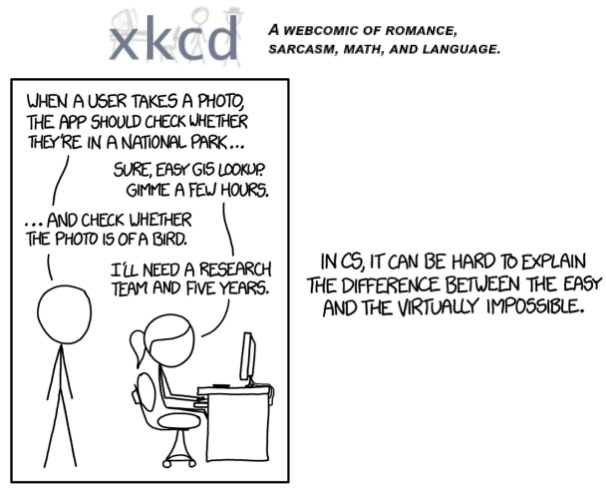

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [10]:
from duckduckgo_search import ddg_images
from fastcore.all import *

# def search_images(term, max_images=30):
#     print(f"Searching for '{term}'")
#     return L(ddg_images(term, max_results=max_images)).itemgot('image')

# Check fastbook is installed
!pip install fastbook
# Import fastbook functions, in our case we'll be using: search_images_ddg
from fastbook import *
# create a function that will take an arbitrary search term and return a list of urls.
def search_images(term, max_images=30):
  print(f"Searching for '{term}'")
  # search_images_ddg comes from fastbook: https://github.com/fastai/fastbook/blob/master/utils.py#L45
  return search_images_ddg(term, max_images=max_images)

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [14]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('Double crested cormorant', max_images=1)
urls[0]

Searching for 'Double crested cormorant'


'https://www.borealbirds.org/sites/default/files/bird_images/double-crested-cormorant.jpg'

...and then download a URL and take a look at it:

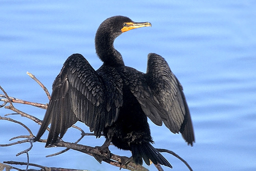

In [15]:
from fastdownload import download_url
dest = 'double_crested_cormorant.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "snowy plover":

Searching for 'snowy plover'


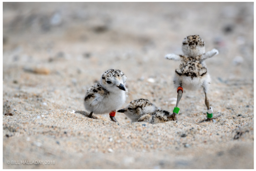

In [13]:
download_url(search_images('snowy plover', max_images=1)[0], 'snowy_plover.jpg', show_progress=False)
Image.open('snowy_plover.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "cormorant" and "snow plover" photos, along with a couple other bird types, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [16]:
searches = 'Double-crested cormorant','snowy plover', 'Black Oystercatcher', 'California Brown Pelican'
path = Path('channel_island_seabirds')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'Double-crested cormorant photo'
Searching for 'Double-crested cormorant sun photo'
Searching for 'Double-crested cormorant shade photo'
Searching for 'snowy plover photo'
Searching for 'snowy plover sun photo'
Searching for 'snowy plover shade photo'
Searching for 'Black Oystercatcher photo'
Searching for 'Black Oystercatcher sun photo'
Searching for 'Black Oystercatcher shade photo'
Searching for 'California Brown Pelican photo'
Searching for 'California Brown Pelican sun photo'
Searching for 'California Brown Pelican shade photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [17]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

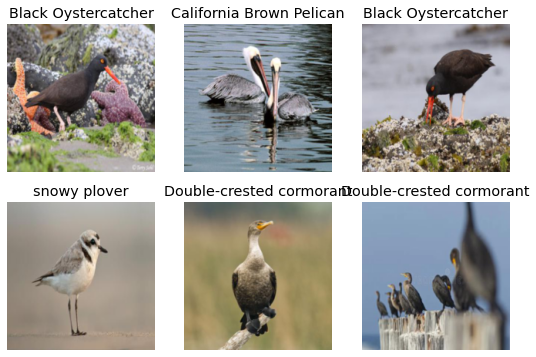

In [18]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "snow plover" or "Double-creted cormorant",etc).

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.534426,0.253102,0.075758,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.246748,0.126780,0.045455,00:02
1,0.154848,0.111253,0.030303,00:01
2,0.107109,0.123292,0.015152,00:01
3,0.076070,0.149166,0.045455,00:01


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [20]:
# This isn't working since we're now a multi-classifier instead of a binary classifier
# This should be fixed
is_plover,_,probs = learn.predict(PILImage.create('snowy_plover.jpg'))
print(f"This is a: {is_plover}.")
print(f"Probability it's a snowy plover: {probs[3]:.4f}")

This is a: snowy plover.
Probability it's a snowy plover: 1.0000


(tensor([[4.0829e-08, 4.5640e-07, 1.5364e-09, 1.0000e+00],
         [5.2565e-05, 2.0537e-05, 1.2598e-05, 9.9991e-01],
         [2.2284e-05, 5.8222e-06, 1.1476e-06, 9.9997e-01],
         [1.8829e-08, 3.8687e-08, 1.5703e-07, 1.0000e+00],
         [7.9879e-06, 3.3591e-09, 8.9468e-08, 9.9999e-01],
         [1.3647e-05, 3.4636e-07, 2.5732e-10, 9.9999e-01],
         [4.4780e-07, 5.2543e-08, 2.0611e-07, 1.0000e+00],
         [5.8507e-06, 1.9404e-09, 4.6223e-08, 9.9999e-01],
         [9.1091e-07, 2.7841e-05, 2.0205e-06, 9.9997e-01],
         [1.3647e-05, 3.4636e-07, 2.5732e-10, 9.9999e-01],
         [1.0589e-06, 9.2227e-08, 1.1261e-06, 1.0000e+00],
         [3.5844e-07, 4.8728e-07, 2.4519e-07, 1.0000e+00],
         [6.1830e-07, 1.6037e-06, 8.0503e-05, 9.9992e-01],
         [7.1316e-06, 3.8215e-07, 1.7285e-07, 9.9999e-01],
         [2.0346e-04, 2.9686e-06, 2.4110e-07, 9.9979e-01],
         [7.1316e-06, 3.8215e-07, 1.7285e-07, 9.9999e-01],
         [1.0747e-08, 2.2368e-09, 7.8276e-09, 1.0000e+00

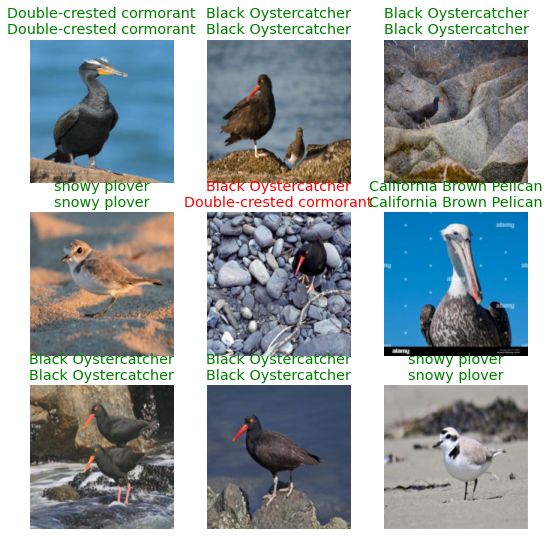

In [22]:
learn.show_results()
test_dl = dls.test_dl(get_image_files('channel_island_seabirds/snowy plover'))

learn.get_preds(dl=test_dl)

Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.